In [361]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

/var/folders/kc/7fz8h6lx1cbdgj_6t2yz73cw0000gn/T/ipykernel_40031/1275802340.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [362]:
df = pd.read_csv("Oil Data.csv")
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,14-Oct-22,85.61,89.27,89.73,85.20,0,-3.93%
1,13-Oct-22,89.11,87.08,89.66,85.56,298.03K,2.11%
2,12-Oct-22,87.27,88.67,90.07,86.28,332.27K,-2.33%
3,11-Oct-22,89.35,91.14,91.35,87.91,333.16K,-1.95%
4,10-Oct-22,91.13,93.48,93.64,90.54,289.51K,-1.63%


In [363]:
df.dropna(axis = 0, inplace=True)

In [364]:
df.Date = pd.to_datetime(df["Date"])
df.index = df['Date']
df.drop("Date", axis = 1, inplace = True)

In [365]:
df = df.sort_index()
df = df.drop(["High", "Open", "Low", "Volume", "Chg%"], axis = 1)
df.head()

,Price
Date,
2022-01-03,76.08
2022-01-04,76.99
2022-01-05,77.85
2022-01-06,79.46
2022-01-07,78.90


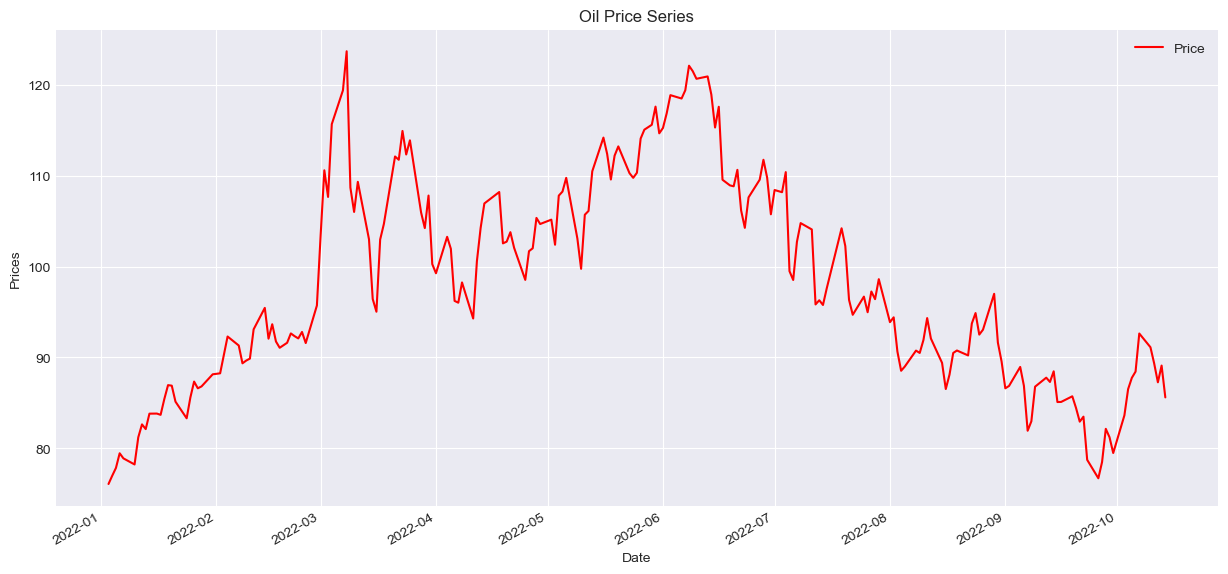

In [366]:
# Plot the price of Oil
df.plot(figsize=(15, 7),color='r')
plt.ylabel("Prices")
plt.title("Oil Price Series")
plt.show()

In [367]:
# Define explanatory variables

df['S_3'] = df["Price"].rolling(window=3).mean()
df['S_9'] = df["Price"].rolling(window=9).mean()
df['next_day_price'] = df["Price"].shift(-1)

df = df.dropna(axis = 0)
X = df[['S_3', 'S_9']]

# Define dependent variable
y = df['next_day_price']

In [368]:
df.head()

,Price,S_3,S_9,next_day_price
Date,,,,
2022-01-13,82.12,81.993333,79.276667,83.82
2022-01-14,83.82,82.860000,80.136667,83.83
2022-01-16,83.83,83.256667,80.896667,83.69
2022-01-17,83.69,83.780000,81.545556,85.43
2022-01-18,85.43,84.316667,82.208889,86.96


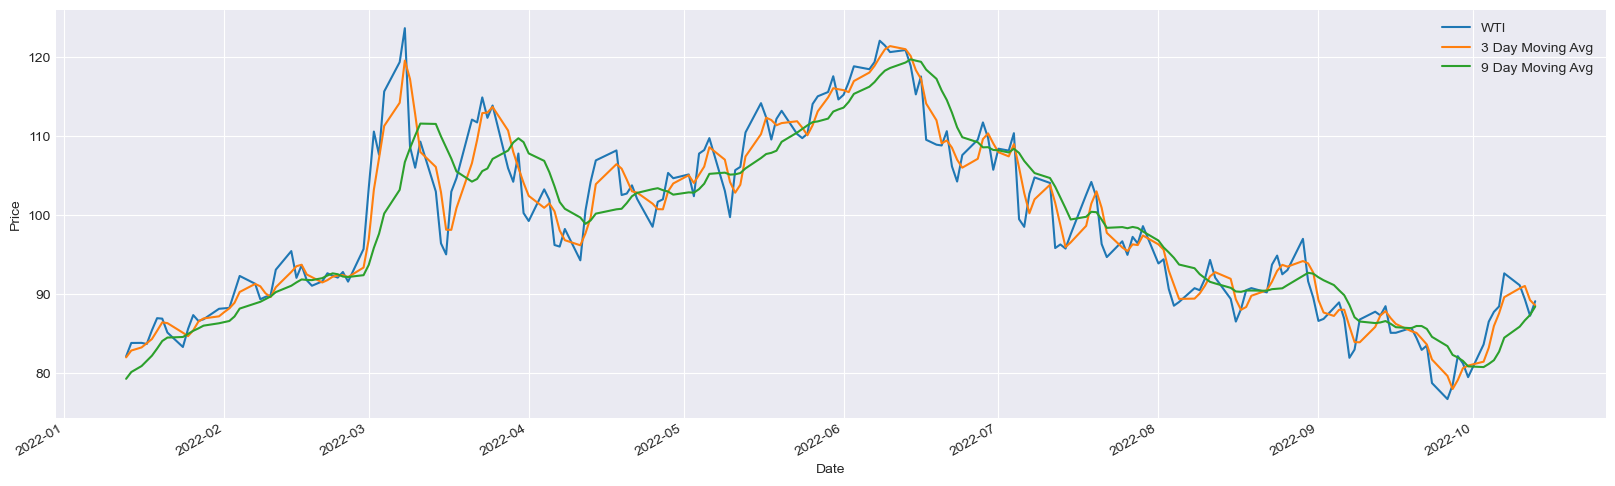

In [369]:
plt.figure(figsize = (20,6))
df["Price"].plot(label='WTI')
df["S_3"].plot(label='3 Day Moving Avg')
df["S_9"].plot(label='9 Day Moving Avg')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [370]:
# Split the data into train and test dataset
t = 0.8
t = int(t*len(df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

In [371]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Oil Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Oil Price (y) = 0.98 * 3 Days Moving Average (x1) + -0.07 * 9 Days Moving Average (x2) + 8.65 (constant)


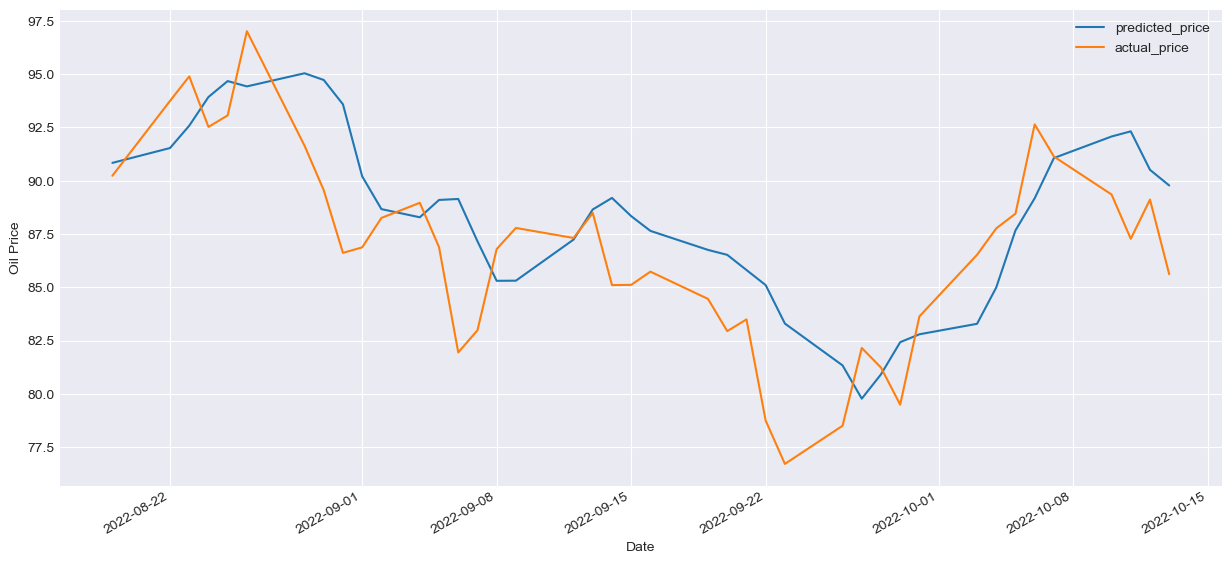

In [372]:
# Predicting the Oil prices For Test Data
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(15, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Oil Price")
plt.show()

In [373]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

46.89

In [374]:
train_pred = linear.predict(X_train)


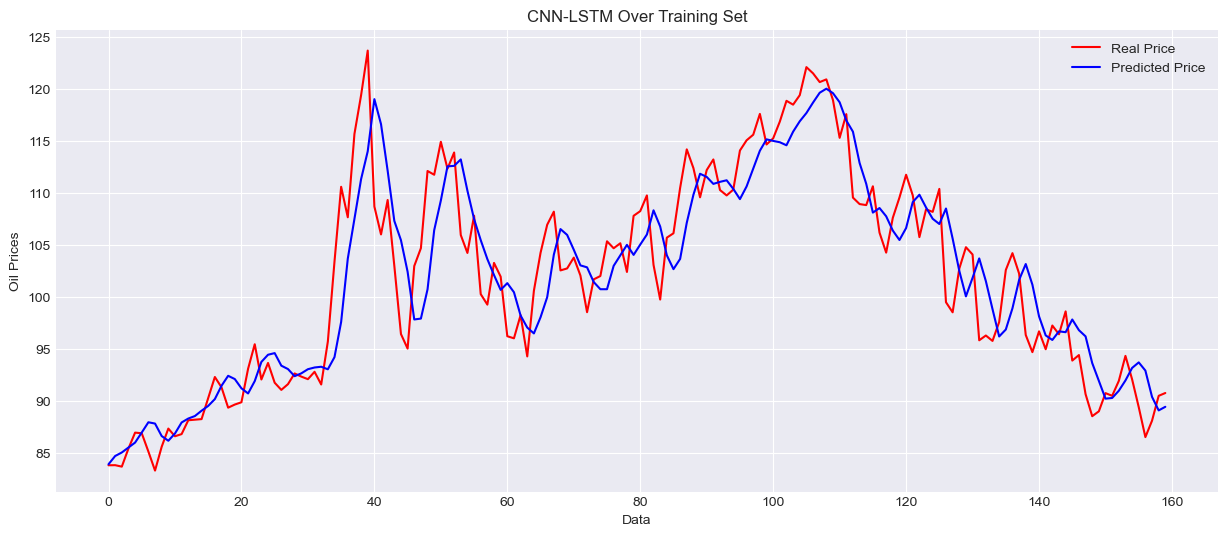

In [375]:
#Plotting Result
plt.figure(figsize = (15,6))
plt.plot([x for x in range(len(y_train))],y_train,color='red')
plt.plot([x for x in range(len(y_train))],train_pred,color='blue')
plt.xlabel('Data')
plt.ylabel('Oil Prices')
plt.title("CNN-LSTM Over Training Set")
plt.legend(['Real Price','Predicted Price'])
plt.show()

In [376]:
df.head()

,Price,S_3,S_9,next_day_price
Date,,,,
2022-01-13,82.12,81.993333,79.276667,83.82
2022-01-14,83.82,82.860000,80.136667,83.83
2022-01-16,83.83,83.256667,80.896667,83.69
2022-01-17,83.69,83.780000,81.545556,85.43
2022-01-18,85.43,84.316667,82.208889,86.96


In [377]:
# The Dual Moving Average Crossover (DMAC) occurs when a short-term average crosses a long-term average
# This signal is used to identify that momentum is shifting in the direction of the short-term average
# A buy signal is generated when the short-term average crosses the long-term average and rises above it, 
# while a sell signal is triggered by a short-term average crossing long-term average and falling below it.

# Function to signal when to buy and when to sell the stock
def DMAC(df) :
    buy_signal = []
    sell_signal = []
    crossing = -1 # When the two SMA crossed past each other
    
    for i in range(len(df)) :
        if df['S_3'][i] > df['S_9'][i] :
            if crossing != 1 :
              buy_signal.append(df['Price'][i])
              sell_signal.append(np.nan)
              crossing = 1
            else :
               buy_signal.append(np.nan)
               sell_signal.append(np.nan)
        elif df['S_3'][i] < df['S_9'][i] :
            if crossing != 0 :
                buy_signal.append(np.nan)
                sell_signal.append(df['Price'][i])
                crossing = 0
            else :
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)
        else :
                buy_signal.append(np.nan)
                sell_signal.append(np.nan)

    return (buy_signal, sell_signal)

In [378]:
# Store the buy and sell data into a variable
DMAC_tuple = DMAC(df)
df['buy_signal'] = DMAC_tuple[0]
df['sell_signal'] = DMAC_tuple[1]
df.head()

/var/folders/kc/7fz8h6lx1cbdgj_6t2yz73cw0000gn/T/ipykernel_40031/2704834944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy_signal'] = DMAC_tuple[0]
/var/folders/kc/7fz8h6lx1cbdgj_6t2yz73cw0000gn/T/ipykernel_40031/2704834944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sell_signal'] = DMAC_tuple[1]


,Price,S_3,S_9,next_day_price,buy_signal,sell_signal
Date,,,,,,
2022-01-13,82.12,81.993333,79.276667,83.82,82.12,NaN
2022-01-14,83.82,82.860000,80.136667,83.83,NaN,NaN
2022-01-16,83.83,83.256667,80.896667,83.69,NaN,NaN
2022-01-17,83.69,83.780000,81.545556,85.43,NaN,NaN
2022-01-18,85.43,84.316667,82.208889,86.96,NaN,NaN


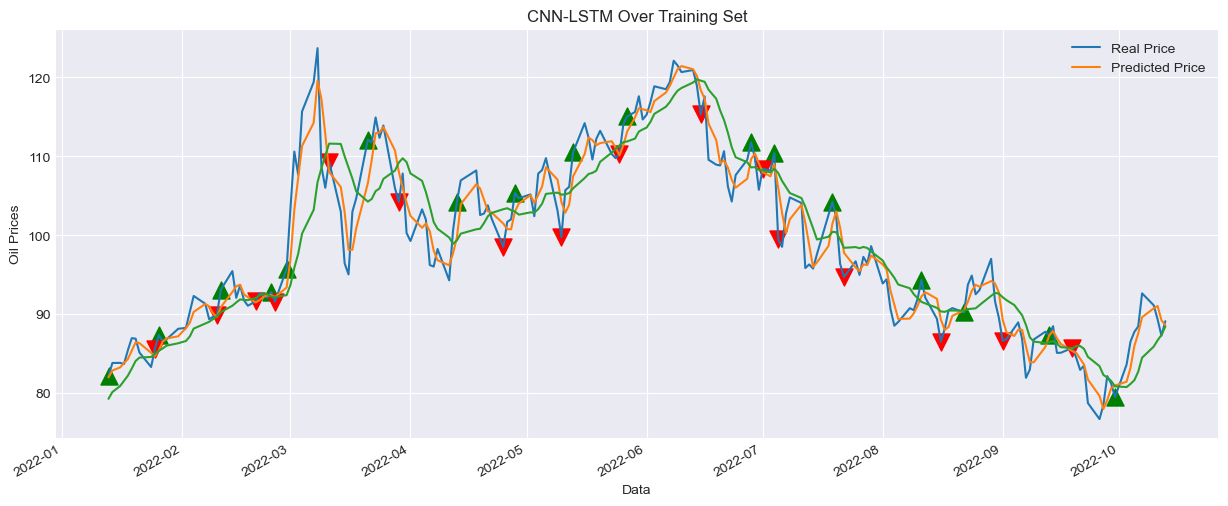

In [379]:
# Plotting the Historical Adjusted Closing Price, the SMAs & the strategy that shows buy and sell signals
plt.figure(figsize = (15,6))
df["Price"].plot(label='WTI')
df["S_3"].plot(label='3 Day Moving Avg')
df["S_9"].plot(label='9 Day Moving Avg')
plt.scatter(df.index, df['buy_signal'], label = 'Buy signal', marker = '^', color = 'green', s = 150)
plt.scatter(df.index, df['sell_signal'], label = 'Sell signal', marker = 'v', color = 'red', s = 150)
plt.xlabel('Data')
plt.ylabel('Oil Prices')
plt.title("CNN-LSTM Over Training Set")
plt.legend(['Real Price','Predicted Price'])
plt.show()